In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from typing import Literal, Optional
from sklearn.manifold import TSNE
from umap import UMAP
import itertools
from pathlib import Path
from loguru import logger
from matplotlib.axes import Axes
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from tueplots import figsizes, fontsizes, fonts, bundles, axes

from histaug.utils import load_features, rc_context, savefig
from histaug.metrics import DISTANCE_METRICS, ensure_tensor
from histaug.utils.display import RENAME_FEATURE_EXTRACTORS, FEATURE_EXTRACTOR_GROUPS

figures_dir = Path("/app/figures/macenko/kather100k")
figures_dir.mkdir(exist_ok=True, parents=True)

N = 10000


feature_extractor_to_group_index = {
    feature_extractor: groupid
    for groupid, feature_extractors in enumerate(FEATURE_EXTRACTOR_GROUPS.values())
    for feature_extractor in feature_extractors
}
feature_extractors = list(itertools.chain.from_iterable(FEATURE_EXTRACTOR_GROUPS.values()))  # [:2]
metric = "cosine"
aug = "Macenko"
# aug = "rotate 90°"

/app/env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/env/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was no

In [2]:
features_by_model = {
    model: load_features(
        f"/data/histaug/features/kather100k/{model}.zarr",
        remove_classes=["BACK"],
        augmentations=(aug,),
        n=N,
    )
    for model in tqdm(feature_extractors)
}

100%|██████████| 12/12 [00:02<00:00,  4.85it/s]


In [3]:
classes = sorted(np.unique(next(iter(features_by_model.values())).labels))
classes

['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

In [4]:
def compute_dists(a: np.ndarray, b: np.ndarray):
    a = ensure_tensor(a)
    b = ensure_tensor(b)
    dists = DISTANCE_METRICS[metric](a, b)
    return dists.numpy()


def compute_interclass_dists(features, n=10000):
    a = np.random.randint(0, len(features.feats), n)
    b = np.random.randint(0, len(features.feats), n)
    while (mask := ((a == b) | (features.labels[a] == features.labels[b]))).any():
        # Resample
        b[mask] = np.random.randint(0, len(features.feats), mask.sum())
    return compute_dists(features.feats[a], features.feats[b])


def compute_intraclass_dists(features, n=10000):
    a = np.random.randint(0, len(features.feats), n)
    b = np.random.randint(0, len(features.feats), n)
    while (mask := ((a == b) | (features.labels[a] != features.labels[b]))).any():
        # Resample
        b[mask] = np.random.randint(0, len(features.feats), mask.sum())
    return compute_dists(features.feats[a], features.feats[b])


def compute_feature_dists(features, n=10000):
    a = np.random.randint(0, len(features.feats), n)
    b = np.random.randint(0, len(features.feats), n)
    while (mask := ((a == b))).any():
        # Resample
        b[mask] = np.random.randint(0, len(features.feats), mask.sum())
    return compute_dists(features.feats[a], features.feats[b])

In [5]:
df = pd.concat(
    itertools.chain.from_iterable(
        (
            pd.DataFrame(
                {
                    "Feature extractor": RENAME_FEATURE_EXTRACTORS[model],
                    "Type": "original $\\leftrightarrow$ stain norm",
                    "Distance": compute_dists(features.feats, features.feats_augs[aug]),
                }
            ),
            pd.DataFrame(
                {
                    "Feature extractor": RENAME_FEATURE_EXTRACTORS[model],
                    "Type": "intra-class",
                    "Distance": compute_intraclass_dists(features),
                }
            ),
            pd.DataFrame(
                {
                    "Feature extractor": RENAME_FEATURE_EXTRACTORS[model],
                    "Type": "inter-class",
                    "Distance": compute_interclass_dists(features),
                }
            ),
            # pd.DataFrame(
            #     {
            #         "Feature extractor": RENAME_FEATURE_EXTRACTORS[model],
            #         "Type": "original $\\leftrightarrow$ random",
            #         "Distance": compute_feature_dists(features),
            #     }
            # ),
        )
        for model, features in features_by_model.items()
    )
)

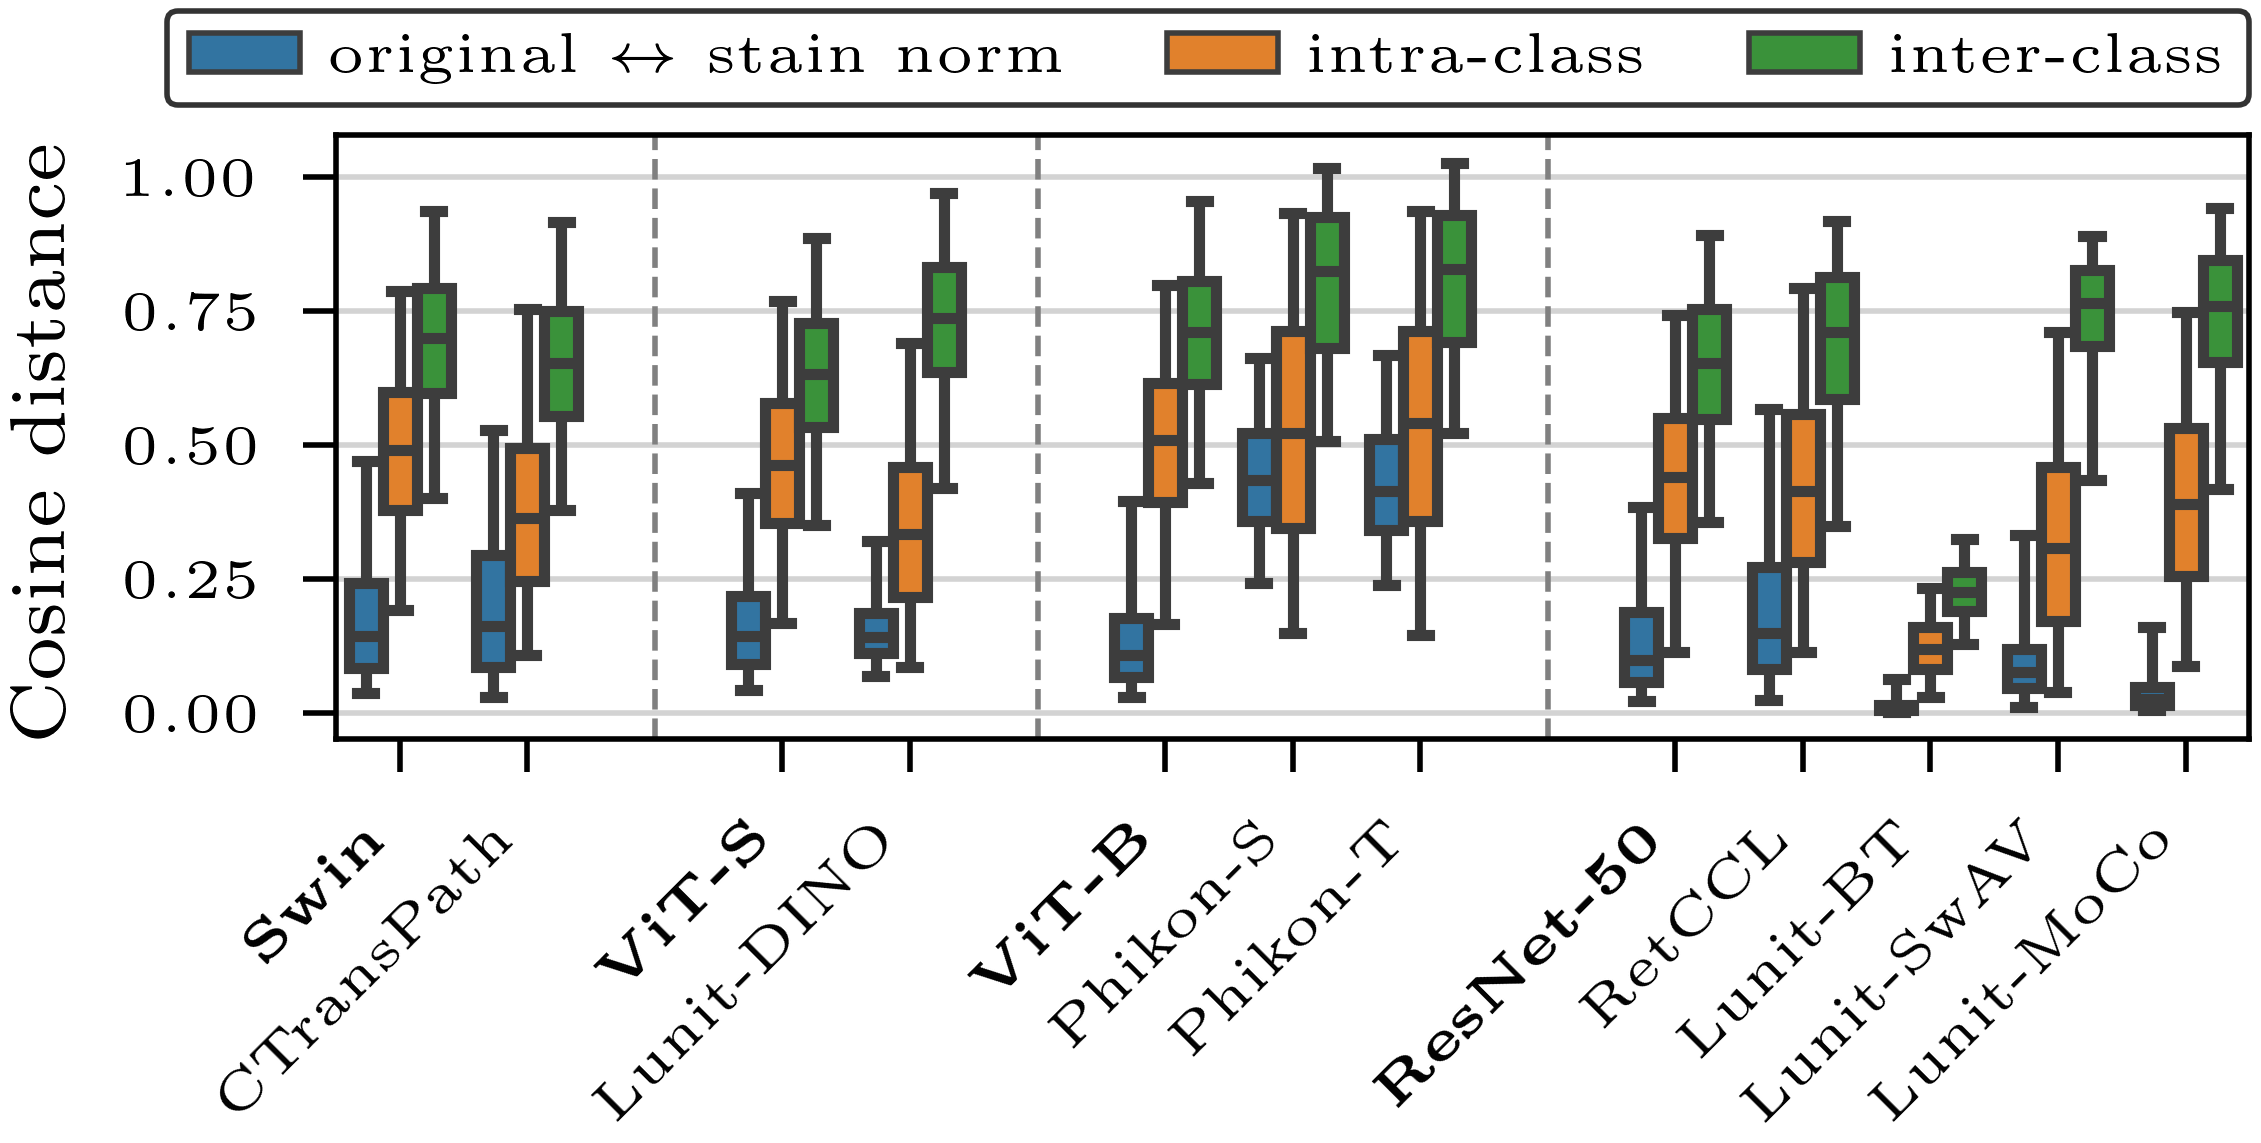

In [6]:
# sns.set_theme(style="whitegrid")
# plt.figure(figsize=(20, 6))
# sns.violinplot(
#     data=df,  # [df["Feature extractor"] != "bt"],
#     x="Feature extractor",
#     y="Distance",
#     hue="Type",
#     fill=False,
#     split=True,
#     inner="quart",
#     density_norm="width",
#     native_scale=True,
# )
# Boxplot with 95% confidence interval
with rc_context(w=0.6, h=1.0, default_smaller=2):

    def format_feature_extractor(new_name: str):
        if new_name in FEATURE_EXTRACTOR_GROUPS:
            return f"\\textbf{{{new_name}}}"
        return new_name

    d = df.copy()
    d["Feature extractor"] = d["Feature extractor"].apply(format_feature_extractor)
    sns.boxplot(
        data=d,
        x="Feature extractor",
        y="Distance",
        hue="Type",
        order=[
            x
            for y in [
                [
                    *([" " * i] if i != 0 else []),
                    *[format_feature_extractor(RENAME_FEATURE_EXTRACTORS[extractor]) for extractor in extractors],
                ]
                for i, extractors in enumerate(FEATURE_EXTRACTOR_GROUPS.values())
            ]
            for x in y
        ],
        # ensure 95% confidence interval is shown
        showfliers=False,
        whis=[2.5, 97.5],
        # showmeans=True,
    )

    plt.legend(
        ncol=3,
        loc="lower right",
        bbox_to_anchor=(1.0, 1.05),
        borderaxespad=0.0,
        columnspacing=1.8,
        handletextpad=0.55,
    )
    plt.ylabel("Cosine distance")

    i = 0
    xticks = []
    for group in FEATURE_EXTRACTOR_GROUPS.values():
        xticks.extend(range(i, i + len(group)))
        if i != 0:
            plt.axvline(x=i - 1, linestyle="--", color="grey", linewidth=0.5)
        i += len(group) + 1

    plt.xticks(xticks, rotation=45, ha="right")

    # light grey grid
    plt.grid(axis="y", color="lightgrey")
    plt.xlabel("")

    savefig("macenko_boxplot")

    plt.show()